In [152]:
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import yfinance as yf
import random

In [153]:
with open('hash-rate.json') as f:
    data = pd.read_json(f)

#https://www.blockchain.com/explorer/charts/hash-rate

In [154]:
with open('miners-revenue.json') as g:
    data2 = pd.read_json('miners-revenue.json', lines=True) 
    
# https://www.blockchain.com/explorer/charts/miners-revenue

## Bitcoin Historical Volatility

In [155]:
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period="10y", interval="1d")
btc_prices = pd.DataFrame(btc_history).reset_index()

btc_prices["Date"] = pd.to_datetime(btc_prices["Date"]).dt.date

start_date = pd.to_datetime('11-01-2020').date()
end_date = pd.to_datetime('01-01-2022').date()
yearly = pd.to_datetime('11-01-2023').date()

# Now perform the filtering
btc_prices_bull = btc_prices[(btc_prices["Date"] >= start_date) & (btc_prices["Date"] <= end_date)]
btc_prices = btc_prices[(btc_prices["Date"] >= start_date)]
btc_prices_bear = btc_prices[(btc_prices["Date"] >= yearly)]

def calculate_historical_volatility(prices, trading_days=252):
    # Step 1: Calculate daily returns
    returns = prices.pct_change().dropna()
    
    # Step 2: Calculate the standard deviation of daily returns
    daily_volatility = np.std(returns)
    
    # Step 3: Annualize the volatility
    annualized_volatility = daily_volatility #* np.sqrt(trading_days)
    
    return annualized_volatility


calculate_historical_volatility(btc_prices["Close"])

0.03270551796670852

In [156]:
def generate_array_prev(N, start, top, end):
    half = N // 2  # Determine the halfway point
    if N % 2 == 0:
        # If N is even, split the increase and decrease evenly
        increasing = np.linspace(start, top, half, endpoint=False)
        decreasing = np.linspace(top, end, half)
    else:
        # If N is odd, make the peak value stay in the middle
        increasing = np.linspace(start, top, half + 1, endpoint=True)
        decreasing = np.linspace(top, end, half + 1)[1:]

    return np.concatenate([increasing, decreasing])


def generate_array(N, start, top, end, volatility = calculate_historical_volatility(btc_prices["Close"]), mean_reversion=.45):
    # Normalize values for better fluctuation visibility
    start_norm = start / start 
    top_norm = top / start 
    end_norm = end / start 
    
    half = N // 2
    mp = ((N  - half) // 2) + half
    q3 = ((N  -  mp) // 2) + mp
    q1 = ((mp  -  half) // 2) + half

    bridge = np.zeros(N)
    bridge[0] = start_norm
    bridge[half] = top_norm
    bridge[-1] = end_norm
    
    for i in range(1, half):
        drift = mean_reversion * (top_norm - bridge[i - 1]) / (half - i)
        shock = np.random.normal(0, volatility)
        bridge[i] = bridge[i - 1] + drift + shock
    
    for i in range(half + 1, N):
        f = 0
        if N <= q1:
            f = N + mp 
        elif (N > q1) and (N <= q3):
            f = N - q1
        else:
            f = N

        drift = mean_reversion * (end_norm - bridge[i - 1]) / (f - i)
        shock = np.random.normal(0, volatility)
        bridge[i] = bridge[i - 1] + drift + shock
    
    # Scale back to original values
    return bridge * start  # Scale back to the original range


### Miner Historical Efficiency Analysis

C:\Users\bfass\AppData\Local\Temp\ipykernel_268\2798550400.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pulled_miners["Release_Year"] = pulled_miners["Date of release"].dt.year
C:\Users\bfass\AppData\Local\Temp\ipykernel_268\2798550400.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pulled_miners['Date_numeric'] = (pulled_miners['Date of release'] - min_date2).dt.days
c:\Users\bfass\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less

                            OLS Regression Results                            
Dep. Variable:      Efficiency (J/Th)   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     157.7
Date:                Sat, 09 Nov 2024   Prob (F-statistic):           5.68e-05
Time:                        19:31:26   Log-Likelihood:                 7.9356
No. Observations:                   7   AIC:                            -11.87
Df Residuals:                       5   BIC:                            -11.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          445.2185     35.194     12.650   

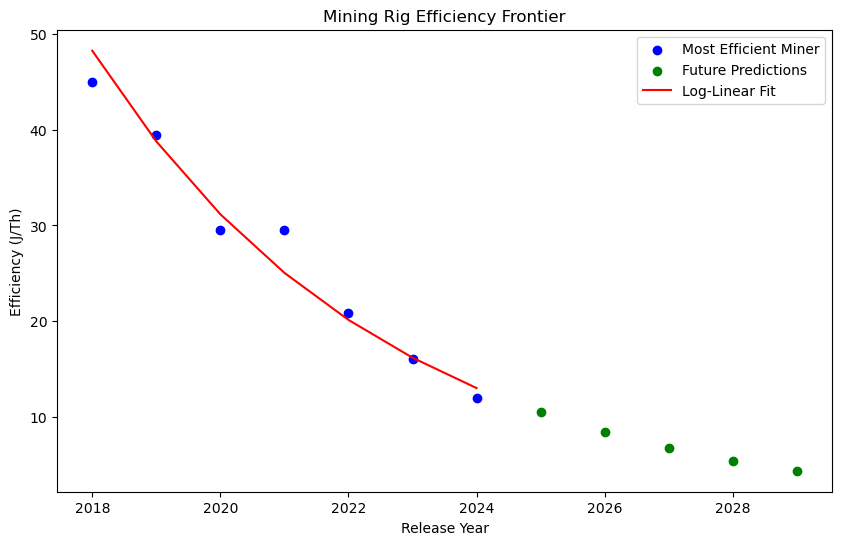

   Release_Year  Predicted_Efficiency
0          2025                 10.44
1          2026                  8.39
2          2027                  6.74
3          2028                  5.42
4          2029                  4.35


In [157]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load and filter the data
pulled_miners_pre = pd.read_excel("History_of_Miners.xlsx")
pulled_miners = pulled_miners_pre[pulled_miners_pre["Date of release"] >= "2018-01-01"]

# Extract release year and create numeric date column
pulled_miners["Release_Year"] = pulled_miners["Date of release"].dt.year
min_date2 = pulled_miners["Date of release"].min()
pulled_miners['Date_numeric'] = (pulled_miners['Date of release'] - min_date2).dt.days

# Aggregate data to get minimum efficiency per year
pm_adj = pulled_miners.groupby("Release_Year")["Efficiency (J/Th)"].min().reset_index()

# Define independent (X) and dependent (y) variables
X = pm_adj["Release_Year"]
y = pm_adj["Efficiency (J/Th)"]

# Apply log transformation to the dependent variable
log_y = np.log(y)

# Add a constant to the independent variable for the intercept
X_with_const = sm.add_constant(X)

# Fit the OLS model on the log-transformed dependent variable
model = sm.OLS(log_y, X_with_const).fit()

# Print the summary of the model
print(model.summary())

# Predict for the original data and back-transform
pm_adj["Log_Predicted_Efficiency"] = np.exp(model.predict(X_with_const))

# Create new years for extrapolation (next 5 years)
last_year = pm_adj["Release_Year"].max()
future_years = np.arange(last_year + 1, last_year + 6)

# Prepare the new data with a constant
future_X_with_const = sm.add_constant(future_years)

# Predict for the next 5 years and back-transform
future_predictions = np.exp(model.predict(future_X_with_const))

# Combine future predictions with original data for plotting
future_data = pd.DataFrame({
    "Release_Year": future_years,
    "Predicted_Efficiency": future_predictions
})

# Plot original data and future predictions
plt.figure(figsize=(10, 6))
plt.scatter(pm_adj["Release_Year"], y, label='Most Efficient Miner', color='blue')
plt.scatter(future_data["Release_Year"], future_data["Predicted_Efficiency"], color='green', label='Future Predictions')
plt.plot(pm_adj["Release_Year"], pm_adj["Log_Predicted_Efficiency"], color='red', label='Log-Linear Fit')


plt.xlabel('Release Year')
plt.ylabel('Efficiency (J/Th)')
plt.title('Mining Rig Efficiency Frontier')
plt.legend()
plt.show()

# Display future predictions
print(future_data)


In [158]:
efficiency_frontier = pd.concat([pm_adj[["Release_Year", "Efficiency (J/Th)"]], future_data.rename(columns={"Predicted_Efficiency": "Efficiency (J/Th)"})])

In [159]:
data[['Time', 'Global-Hashrate']] = data['hash-rate'].apply(pd.Series)
data[['Time', 'BTC']] = data['market-price'].apply(pd.Series)
data['date'] = pd.to_datetime(data['Time'], unit='ms')

In [160]:
new_df = data[['Time', 'BTC', 'Global-Hashrate', 'date']]

miner_rev = pd.DataFrame(data2["miners-revenue"][0])
miner_rev.columns = ['Time', 'Avg_Miner_Reward']

miner_rev['date_pre'] = pd.to_datetime(miner_rev['Time'], unit='ms')
miner_rev['date']  = miner_rev['date_pre'] + (new_df["date"].max() - miner_rev['date_pre'].max())

In [161]:
final_df = new_df.merge(miner_rev[["date", "Avg_Miner_Reward"]], on='date', how='left')
final_df = final_df[final_df["date"] >= '2020-01-01']

min_date = final_df['date'].min()
final_df['days_from_min'] = (final_df['date'] - min_date).dt.days
final_df["Hash_Price"] = (final_df["Avg_Miner_Reward"] * 1000)/final_df["Global-Hashrate"]

In [162]:
final_df[["BTC", "Global-Hashrate", "Avg_Miner_Reward", "days_from_min", "Hash_Price"]]

,BTC,Global-Hashrate,Avg_Miner_Reward,days_from_min,Hash_Price
1002,"7,255.40","97,011,480.59","13,152,944.22",0,135.58
1003,"7,217.24","105,793,194.82","15,650,931.39",4,147.94
1004,"7,438.65","107,202,820.50","14,890,476.72",8,138.90
1005,"7,906.14","105,144,996.71","15,625,350.67",12,148.61
1006,"8,279.94","106,142,030.58","17,478,168.64",16,164.67
...,...,...,...,...,...
1441,"67,700.44","723,631,693.13","37,717,977.99",1756,52.12
1442,"67,907.65","735,533,947.47","34,823,376.26",1760,47.34
1443,"67,670.98","735,808,128.70","36,386,425.46",1764,49.45
1444,"69,945.28","752,114,126.01","32,026,078.60",1768,42.58


In [163]:
final_df2 = final_df.copy()
final_df2["Global-Hashrate"] = final_df2["Global-Hashrate"] / 1000
final_df2["Hash_Price"] = final_df2["Avg_Miner_Reward"] / final_df2["Global-Hashrate"]
final_df2["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / final_df2["BTC"]) / 144
final_df2["Year"] = final_df2["date"].dt.year
final_df2 = final_df2.merge(efficiency_frontier, how = 'left', left_on="Year", right_on = "Release_Year")
final_df2.drop(columns = "Release_Year", inplace = True)

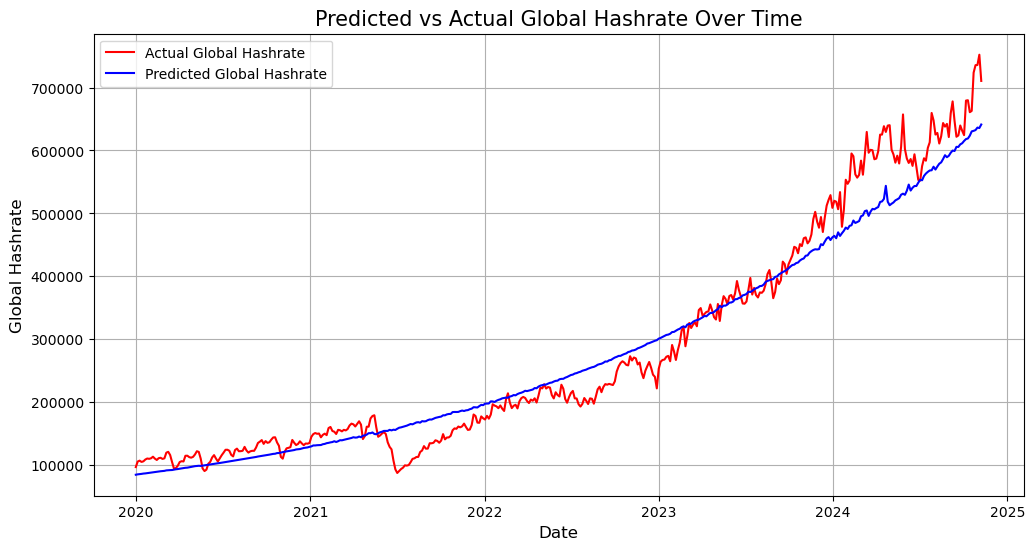

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Ensure date is in datetime format
final_df2['date'] = pd.to_datetime(final_df2['date'])

# Prepare input features and target variable
x = final_df2[["BTC", "Avg_Miner_Reward", "days_from_min"]]
y = final_df2["Global-Hashrate"]

# Transform the target variable with the natural logarithm
log_y = np.log(y)

# Fit linear regression model on transformed data
model = LinearRegression().fit(x, log_y)

# Predict in log scale and convert back by exponentiating
log_y_pred = model.predict(x)
y_pred = np.exp(log_y_pred)

# Time series plot: Actual vs Predicted Global Hashrate
plt.figure(figsize=(12, 6))
plt.plot(final_df2['date'], y, color='red', label='Actual Global Hashrate')  # Actual values
plt.plot(final_df2['date'], y_pred, color='blue', label='Predicted Global Hashrate')  # Predicted values

# Formatting the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Global Hashrate', fontsize=12)
plt.title('Predicted vs Actual Global Hashrate Over Time', fontsize=15)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [165]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calculate performance metrics
r2 = r2_score(y, y_pred)  # R-squared
mse = mean_squared_error(y, y_pred)  # Mean Squared Error
mae = mean_absolute_error(y, y_pred)  # Mean Absolute Error

print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

R²: 0.9538
MSE: 1507569050.4316
MAE: 29595.5400


## Projecting Data into the future

In [166]:
proj = final_df2[["date","days_from_min", "BTC", "Avg_Miner_Reward"]]
proj["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / 144) / final_df2["BTC"]
proj

dates_array = pd.date_range(start='2024-10-10', end='2028-05-01', freq='4D')
reference_date = final_df['date'].min()
days_from_reference = (dates_array - reference_date).days
BTC = np.array(generate_array(len(dates_array), final_df2["BTC"].iloc[-1] ,150000, random.uniform(75000, 125000)))


guess = pd.DataFrame({
    "date": dates_array,
    "days_from_min":days_from_reference,
    "BTC_Base": BTC,
    "Avg_Miner_Reward": BTC * 144 * 3.4,
    "Block_Rewards": 3.4
})

proj = pd.concat([proj, guess], axis=0)

#efficiency_frontier = pd.concat([pm_adj[["Release_Year", "Efficiency (J/Th)"]], future_data.rename(columns={"Predicted_Efficiency": "Efficiency (J/Th)"})])

proj["Year"] = proj["date"].dt.year
proj = proj.merge(efficiency_frontier, how = 'left', left_on="Year", right_on = "Release_Year")
proj.drop(columns = "Release_Year", inplace = True)

C:\Users\bfass\AppData\Local\Temp\ipykernel_268\1478108810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proj["Block_Rewards"] = (final_df2["Avg_Miner_Reward"] / 144) / final_df2["BTC"]


## BTC Projections

In [167]:
bear = np.array(generate_array(len(dates_array), final_df2["BTC"].iloc[-1],60000,  random.uniform(55000, 70000), volatility = calculate_historical_volatility(btc_prices_bear["Close"])))
base = BTC
bull = np.array(generate_array(len(dates_array), final_df2["BTC"].iloc[-1] ,250000, random.uniform(125000, 175000), volatility = calculate_historical_volatility(btc_prices_bull["Close"])))

btc_proj = pd.DataFrame({
    "date": dates_array,
    "BTC_Bear": bear,
    "BTC_Base": base,
    "BTC_Bull": bull,
    "Block_Rewards": 3.4 
})

btc_proj = pd.concat([final_df2[["date", "BTC"]], btc_proj], axis=0)

proj_pre = proj.merge(btc_proj[["date", "BTC_Bear", "BTC_Bull"]], on = 'date', how = 'left')
proj_pre = proj_pre[proj_pre["date"] > final_df2["date"].max()]

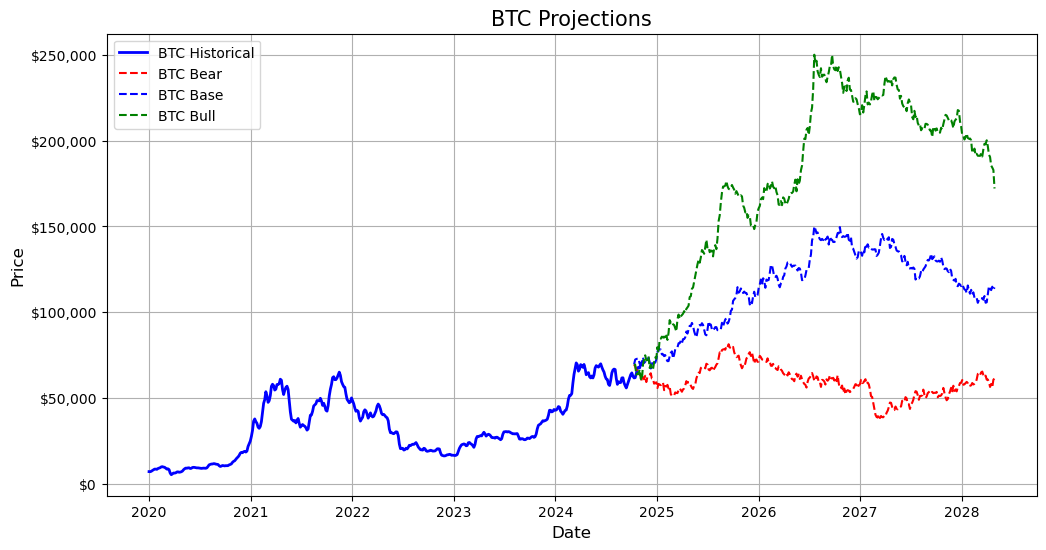

In [168]:
# Plot the data
plt.figure(figsize=(12, 6))

def dollar_formatter(x, pos):
    return f'${int(x):,}'

# Plot each column as a line
plt.plot(btc_proj['date'], btc_proj['BTC'], label='BTC Historical', color='blue', linewidth=2)
plt.plot(btc_proj['date'], btc_proj['BTC_Bear'], label='BTC Bear', color='red', linestyle='--')
plt.plot(btc_proj['date'], btc_proj['BTC_Base'], label='BTC Base', color='blue', linestyle='--')
plt.plot(btc_proj['date'], btc_proj['BTC_Bull'], label='BTC Bull', color='green', linestyle='--')

# Add title and labels
plt.title('BTC Projections', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

plt.gca().yaxis.set_major_formatter(FuncFormatter(dollar_formatter))
# Add legend
plt.legend(loc='best')

# Display grid for better readability
plt.grid(True)

# Show the plot
plt.show()

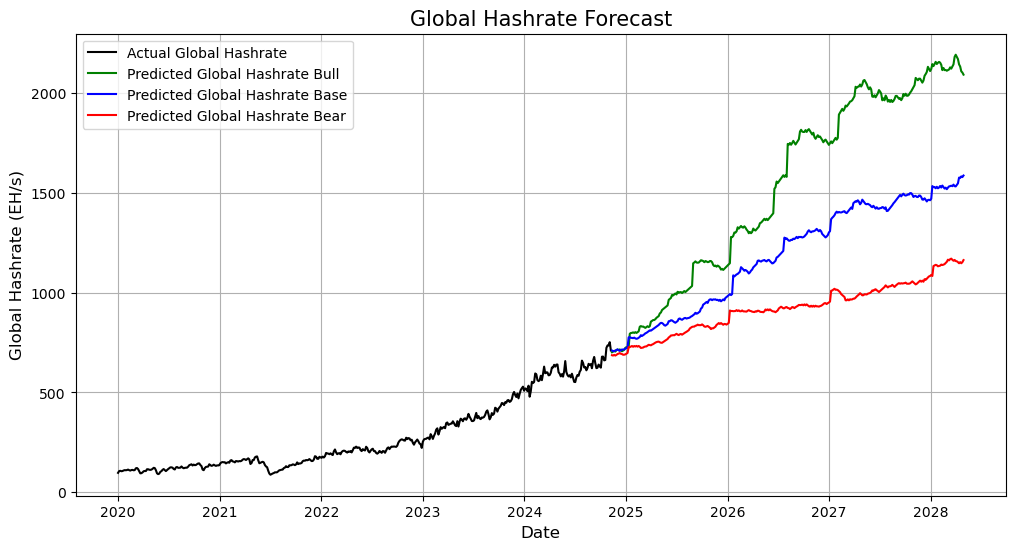

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LinearRegression

btc_scaling_factor = 0.2

# Ensure date is in datetime format
final_df2['date'] = pd.to_datetime(final_df2['date'])

# Prepare input features and target variable
x = final_df2[["BTC", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]]
y = final_df2["Global-Hashrate"]

# Transform the target variable with the natural logarithm
log_y = np.log(y)

# Fit linear regression model on transformed data
model = LinearRegression().fit(x, log_y)

## Base
x2 = proj_pre[["BTC_Base", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Base": "BTC"}).dropna()
# Bear and Bull
x1 = proj_pre[["BTC_Bear", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Bear": "BTC"}).dropna()
x3 = proj_pre[["BTC_Bull", "Block_Rewards", "days_from_min", "Efficiency (J/Th)"]].rename(columns={"BTC_Bull": "BTC"}).dropna()

def thousands_formatter(x, pos):
    return f'{int(x * 1e-3)}'

def cap_changes(predictions, max_change_percent):
    """Cap the percentage change in predictions."""
    capped_predictions = predictions.copy()
    for i in range(1, len(predictions)):
        change = (predictions[i] - predictions[i - 1]) / predictions[i - 1]
        if abs(change) > max_change_percent:
            capped_predictions[i] = capped_predictions[i - 1] * (1 + max_change_percent * np.sign(change))
    return capped_predictions

## Predict in log scale and convert back by exponentiating, Calculate initial predictions without applying growth factors
log_y_pred = model.predict(x2)
log_y_pred_bear = model.predict(x1)
log_y_pred_bull = model.predict(x3)

start_adj = final_df2["Global-Hashrate"].iloc[-1] - np.exp(log_y_pred)[0]
# Convert from log scale to actual scale
y_pred = (np.exp(log_y_pred) * np.linspace(1, .7, len(log_y_pred))) + start_adj
y_pred_bear = (np.exp(log_y_pred_bear) * np.linspace(1, .6, len(log_y_pred_bear))) + start_adj
y_pred_bull = (np.exp(log_y_pred_bull) * np.linspace(1, .75 , len(log_y_pred_bull))) + start_adj

# Cap the percentage change in predictions (e.g., 5% change)
max_change_percent = 0.005  # Adjust this value as needed
y_pred_capped = cap_changes(y_pred, max_change_percent)
y_pred_bear_capped = cap_changes(y_pred_bear, max_change_percent)
y_pred_bull_capped = cap_changes(y_pred_bull, max_change_percent)

# Time series plot: Actual vs Predicted Global Hashrate
plt.figure(figsize=(12, 6))
plt.plot(final_df2['date'], y, color='black', label='Actual Global Hashrate')  # Actual values
plt.plot(proj_pre['date'], y_pred_bull_capped, color='green', label='Predicted Global Hashrate Bull')  # Capped predicted values
plt.plot(proj_pre['date'], y_pred_capped, color='blue', label='Predicted Global Hashrate Base')  # Capped predicted values
plt.plot(proj_pre['date'], y_pred_bear_capped, color='red', label='Predicted Global Hashrate Bear')  # Capped predicted values

# Formatting the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Global Hashrate (EH/s)', fontsize=12)
plt.title('Global Hashrate Forecast', fontsize=15)
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Show the plot
plt.show()


### Hash Price Forecast

C:\Users\bfass\AppData\Local\Temp\ipykernel_268\1068106630.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_forecast["Hash_Price_Base"] = (hp_forecast["BTC_Base"] * hp_forecast["Block_Rewards"] * 144)/hp_forecast["predicted_global_base"]
C:\Users\bfass\AppData\Local\Temp\ipykernel_268\1068106630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hp_forecast["Hash_Price_Bear"] = (hp_forecast["BTC_Bear"] * hp_forecast["Block_Rewards"] * 144)/hp_forecast["predicted_global_bear"]
C:\Users\bfass\AppData

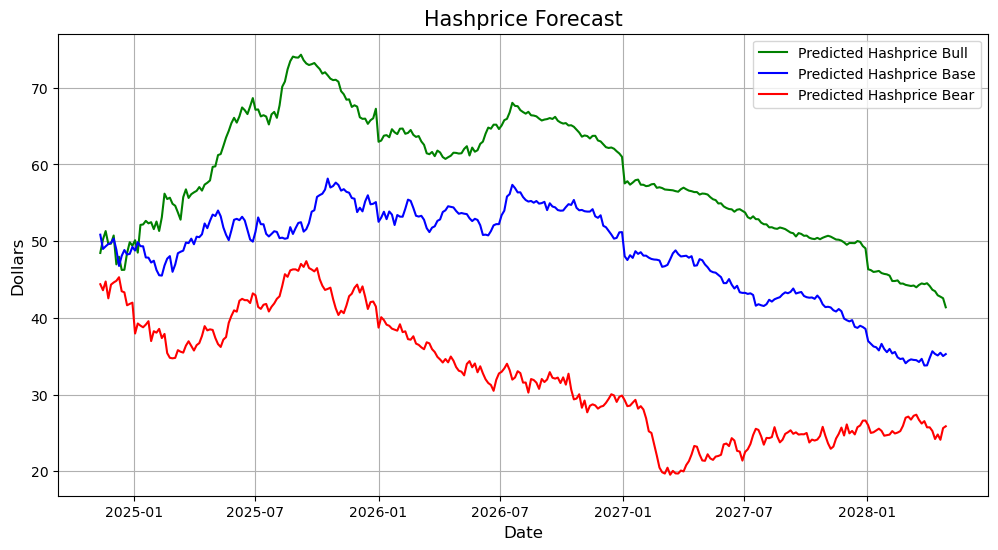

In [171]:
proj_pre["Avg_Miner_Reward_bear"] = proj_pre["BTC_Bear"] * 144 * proj_pre["Block_Rewards"]
proj_pre["Avg_Miner_Reward_bull"] = proj_pre["BTC_Bull"] * 144 * proj_pre["Block_Rewards"]
proj_pre["predicted_global_bear"] = y_pred_bear
proj_pre["predicted_global_base"] = y_pred
proj_pre["predicted_global_bull"] = y_pred_bull

hp_forecast = proj_pre[['date', 'BTC', 'Avg_Miner_Reward', 'Block_Rewards', 'BTC_Bear', 'BTC_Bull', 'BTC_Base', 'predicted_global_bear', 'predicted_global_base', 'predicted_global_bull']]


hp_forecast["Hash_Price_Base"] = (hp_forecast["BTC_Base"] * hp_forecast["Block_Rewards"] * 144)/hp_forecast["predicted_global_base"]
hp_forecast["Hash_Price_Bear"] = (hp_forecast["BTC_Bear"] * hp_forecast["Block_Rewards"] * 144)/hp_forecast["predicted_global_bear"]
hp_forecast["Hash_Price_Bull"] = (hp_forecast["BTC_Bull"] * hp_forecast["Block_Rewards"] * 144)/hp_forecast["predicted_global_bull"]

# Time series plot: Actual vs Predicted Global Hashrate
plt.figure(figsize=(12, 6))
#plt.plot(final_df2['date'], final_df2["Hash_Price"], color='black', label='Actual Global Hashprice')  # Actual values
plt.plot(hp_forecast['date'], hp_forecast["Hash_Price_Bull"], color='green', label='Predicted Hashprice Bull')  # Capped predicted values
plt.plot(hp_forecast['date'], hp_forecast["Hash_Price_Base"], color='blue', label='Predicted Hashprice Base')  # Capped predicted values
plt.plot(hp_forecast['date'], hp_forecast["Hash_Price_Bear"], color='red', label='Predicted Hashprice Bear')  # Capped predicted values

# Formatting the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Dollars', fontsize=12)
plt.title('Hashprice Forecast', fontsize=15)
plt.legend()
plt.grid(True)

#plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Show the plot
plt.show()

In [172]:
print(y_pred_bull_capped[-1] / (y.iloc[-1] * 2.2))
print(y_pred_capped[-1] / (y.iloc[-1] * 2))
print(y_pred_bear_capped[-1] / (y.iloc[-1] * 1.8))


1.3391458927941142
1.117146551951026
0.9098259118760379


In [173]:
## Iren Says buildout is $650K per MW
## Iren spot pricing of .035 per kilowatt hour

## After we project gross margin and pay pay back period. Scale up to total based on available mw to factor in sga cost and 
## Find at what point does electricity cost outweigh the revenue?


power_c = .035


btc_miner_rigs = pd.DataFrame({
    "Rigs": ["S21 XP", "S21 Pro"],
    "W": [3654, 3510],
    "J/Th": [13.5, 15],
    "Base Cost": [8289, 6318] #,
    ##"Bulk Cost": [4000, 3750] #based on penny saying clsk paid $16 per terahash
})

btc_miner_rigs["Daily_Cost"] = (btc_miner_rigs["W"] / 1000) * power_c * 24


btc_miner_rigs["THps"] = btc_miner_rigs["W"] / btc_miner_rigs["J/Th"]
btc_miner_rigs["PHps"] = (btc_miner_rigs["W"] / btc_miner_rigs["J/Th"])/1000

btc_miner_rigs["Bulk Cost"] = btc_miner_rigs["THps"] * 21 ## Iren purchased them August S21 XP for $21 a terahash
btc_miner_rigs["Rigs In MW"] = 1000000 / btc_miner_rigs["W"]
btc_miner_rigs["Rigs per Eh/s"] = 1000000 / btc_miner_rigs["THps"]

btc_miner_rigs["MWs per Eh/s"] = btc_miner_rigs["Rigs per Eh/s"] / btc_miner_rigs["Rigs In MW"]

In [174]:
btc_miner_rigs

,Rigs,W,J/Th,Base Cost,Daily_Cost,THps,PHps,Bulk Cost,Rigs In MW,Rigs per Eh/s,MWs per Eh/s
0,S21 XP,3654,13.50,8289,3.07,270.67,0.27,"5,684.00",273.67,"3,694.58",13.50
1,S21 Pro,3510,15.00,6318,2.95,234.00,0.23,"4,914.00",284.90,"4,273.50",15.00


In [175]:




proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"] = btc_miner_rigs["Daily_Cost"][0] * 4
proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc"] = btc_miner_rigs["Daily_Cost"][0] * 4 / proj_pre["BTC_Base"]
proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc_bear"] = btc_miner_rigs["Daily_Cost"][0] * 4 / proj_pre["BTC_Bear"]
proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc_bull"] = btc_miner_rigs["Daily_Cost"][0] * 4 / proj_pre["BTC_Bull"]


proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bear"] =  4 * proj_pre["Avg_Miner_Reward_bear"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bear"])
proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_base"] =  4 * proj_pre["Avg_Miner_Reward"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_base"])
proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bull"] =  4 * proj_pre["Avg_Miner_Reward_bull"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bull"])

proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_bear"] =  4 * 144 * proj_pre["Block_Rewards"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bear"])
proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_base"] =  4 * 144 * proj_pre["Block_Rewards"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_base"])
proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_bull"] =  4 * 144 * proj_pre["Block_Rewards"] * (btc_miner_rigs["PHps"][0] / proj_pre["predicted_global_bull"])


proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bear"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]
proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_base"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]
proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "Rev_bull"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c"]

proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear_btc"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_bear"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc_bear"]
proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base_btc"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_base"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc"]
proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull_btc"] =  proj_pre[btc_miner_rigs["Rigs"][0] + "BTC_Rev_bull"] - proj_pre[btc_miner_rigs["Rigs"][0] + "daily_c_btc_bull"]


proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bear"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear"].cumsum()
proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_base"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base"].cumsum()
proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bull"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull"].cumsum()

proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bear_btc"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bear_btc"].cumsum()
proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_base_btc"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_base_btc"].cumsum()
proj_pre[btc_miner_rigs["Rigs"][0] + "_cumulative_profit_bull_btc"] = proj_pre[btc_miner_rigs["Rigs"][0] + "Prof_bull_btc"].cumsum()

In [176]:
pd.set_option('display.precision', 10)

# Display the specified columns without rounding
proj_pre[['S21 XPBTC_Rev_bear', 'S21 XPBTC_Rev_base', 'S21 XPBTC_Rev_bull', 
          'S21 XPdaily_c_btc', 'S21 XPdaily_c_btc_bear', 'S21 XPdaily_c_btc_bull']]

print(proj_pre['S21 XPBTC_Rev_bear'].iloc[1])
print(proj_pre['S21 XPdaily_c_btc_bear'].iloc[1])

0.0007738637204803368
0.00020125045459013012


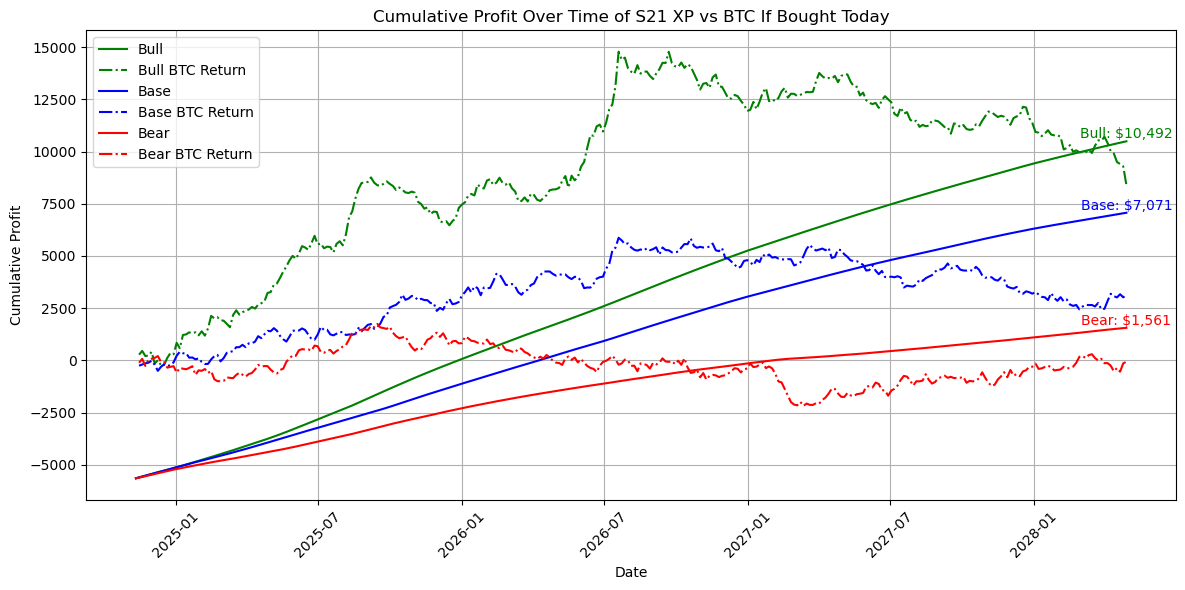

In [177]:
bulk_cost_offset = btc_miner_rigs["Bulk Cost"][0]

proj_pre["BTC_Base_CumReturn"] = ((1 + proj_pre["BTC_Base"].pct_change()).cumprod() - 1) * bulk_cost_offset
proj_pre["BTC_Bear_CumReturn"] = ((1 + proj_pre["BTC_Bear"].pct_change()).cumprod() - 1) * bulk_cost_offset
proj_pre["BTC_Bull_CumReturn"] = ((1 + proj_pre["BTC_Bull"].pct_change()).cumprod() - 1) * bulk_cost_offset

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(proj_pre['date'], proj_pre['S21 XP_cumulative_profit_bull'] - bulk_cost_offset, label='Bull', color='green')
plt.plot(proj_pre['date'], proj_pre['BTC_Bull_CumReturn'], label='Bull BTC Return', color='green', linestyle='-.')

plt.plot(proj_pre['date'], proj_pre['S21 XP_cumulative_profit_base'] - bulk_cost_offset, label='Base', color='blue')
plt.plot(proj_pre['date'], proj_pre['BTC_Base_CumReturn'], label='Base BTC Return', color='blue', linestyle='-.')

plt.plot(proj_pre['date'], proj_pre['S21 XP_cumulative_profit_bear'] - bulk_cost_offset, label='Bear', color='red')
plt.plot(proj_pre['date'], proj_pre['BTC_Bear_CumReturn'], label='Bear BTC Return', color='red', linestyle='-.')

# Bold line at y = 0
#plt.axhline(0, color='black', linewidth=2, linestyle='--')  # Add a bold dashed line at y=0

# Adding labels at the end of each line
last_date = proj_pre['date'].iloc[-1]
bull_last_value = proj_pre['S21 XP_cumulative_profit_bull'].iloc[-1] - bulk_cost_offset
base_last_value = proj_pre['S21 XP_cumulative_profit_base'].iloc[-1] - bulk_cost_offset
bear_last_value = proj_pre['S21 XP_cumulative_profit_bear'].iloc[-1] - bulk_cost_offset

# Formatting and placing the text labels with dollar format
plt.text(last_date, bull_last_value, f'Bull: ${bull_last_value:,.0f}', color='green', ha='center', va='bottom')
plt.text(last_date, base_last_value, f'Base: ${base_last_value:,.0f}', color='blue', ha='center', va='bottom')
plt.text(last_date, bear_last_value, f'Bear: ${bear_last_value:,.0f}', color='red', ha='center', va='bottom')


# Formatting the plot
plt.title('Cumulative Profit Over Time of S21 XP vs BTC If Bought Today')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


## Returns in Bitcoin

In [178]:
proj_pre.columns

Index(['date', 'days_from_min', 'BTC', 'Avg_Miner_Reward', 'Block_Rewards',
       'BTC_Base', 'Year', 'Efficiency (J/Th)', 'BTC_Bear', 'BTC_Bull',
       'Avg_Miner_Reward_bear', 'Avg_Miner_Reward_bull',
       'predicted_global_bear', 'predicted_global_base',
       'predicted_global_bull', 'S21 XPdaily_c', 'S21 XPdaily_c_btc',
       'S21 XPdaily_c_btc_bear', 'S21 XPdaily_c_btc_bull', 'S21 XPRev_bear',
       'S21 XPRev_base', 'S21 XPRev_bull', 'S21 XPBTC_Rev_bear',
       'S21 XPBTC_Rev_base', 'S21 XPBTC_Rev_bull', 'S21 XPProf_bear',
       'S21 XPProf_base', 'S21 XPProf_bull', 'S21 XPProf_bear_btc',
       'S21 XPProf_base_btc', 'S21 XPProf_bull_btc',
       'S21 XP_cumulative_profit_bear', 'S21 XP_cumulative_profit_base',
       'S21 XP_cumulative_profit_bull', 'S21 XP_cumulative_profit_bear_btc',
       'S21 XP_cumulative_profit_base_btc',
       'S21 XP_cumulative_profit_bull_btc', 'BTC_Base_CumReturn',
       'BTC_Bear_CumReturn', 'BTC_Bull_CumReturn'],
      dtype='object')

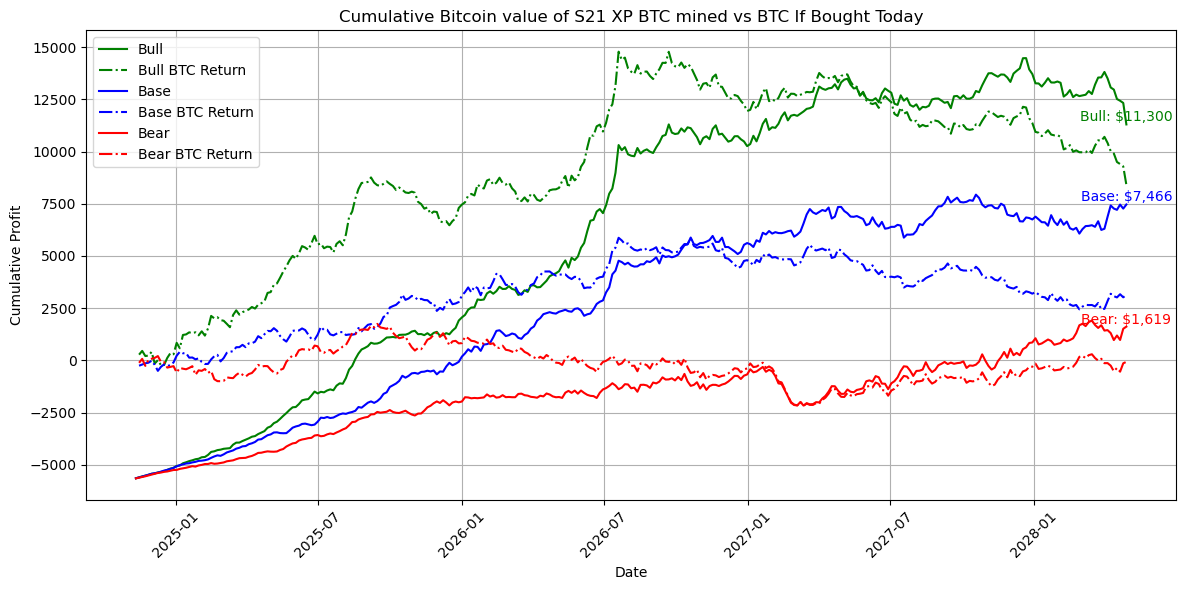

In [179]:
bulk_cost_offset_btc = btc_miner_rigs["Bulk Cost"][0] 

proj_pre["BTC_Base_CumReturn"] = ((1 + proj_pre["BTC_Base"].pct_change()).cumprod() - 1) * bulk_cost_offset_btc
proj_pre["BTC_Bear_CumReturn"] = ((1 + proj_pre["BTC_Bear"].pct_change()).cumprod() - 1) * bulk_cost_offset_btc
proj_pre["BTC_Bull_CumReturn"] = ((1 + proj_pre["BTC_Bull"].pct_change()).cumprod() - 1) * bulk_cost_offset_btc

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(proj_pre['date'], (proj_pre['S21 XP_cumulative_profit_bull_btc'] * proj_pre["BTC_Bull"]) - bulk_cost_offset, label='Bull', color='green')
plt.plot(proj_pre['date'], proj_pre['BTC_Bull_CumReturn'], label='Bull BTC Return', color='green', linestyle='-.')

plt.plot(proj_pre['date'], (proj_pre['S21 XP_cumulative_profit_base_btc'] * proj_pre["BTC_Base"]) - bulk_cost_offset, label='Base', color='blue')
plt.plot(proj_pre['date'], proj_pre['BTC_Base_CumReturn'], label='Base BTC Return', color='blue', linestyle='-.')

plt.plot(proj_pre['date'], (proj_pre['S21 XP_cumulative_profit_bear_btc'] * proj_pre["BTC_Bear"]) - bulk_cost_offset, label='Bear', color='red')
plt.plot(proj_pre['date'], proj_pre['BTC_Bear_CumReturn'], label='Bear BTC Return', color='red', linestyle='-.')

# Bold line at y = 0
#plt.axhline(0, color='black', linewidth=2, linestyle='--')  # Add a bold dashed line at y=0

# Adding labels at the end of each line
last_date = proj_pre['date'].iloc[-1]
bull_last_value = (proj_pre['S21 XP_cumulative_profit_bull_btc'] * proj_pre["BTC_Bull"]).iloc[-1] - bulk_cost_offset_btc
base_last_value = (proj_pre['S21 XP_cumulative_profit_base_btc'] * proj_pre["BTC_Base"]).iloc[-1] - bulk_cost_offset_btc
bear_last_value = (proj_pre['S21 XP_cumulative_profit_bear_btc'] * proj_pre["BTC_Bear"]).iloc[-1] - bulk_cost_offset_btc

# Formatting and placing the text labels with dollar format
plt.text(last_date, bull_last_value, f'Bull: ${bull_last_value:,.0f}', color='green', ha='center', va='bottom')
plt.text(last_date, base_last_value, f'Base: ${base_last_value:,.0f}', color='blue', ha='center', va='bottom')
plt.text(last_date, bear_last_value, f'Bear: ${bear_last_value:,.0f}', color='red', ha='center', va='bottom')


# Formatting the plot
plt.title('Cumulative Bitcoin value of S21 XP BTC mined vs BTC If Bought Today')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


In [180]:
proj_pre.columns

Index(['date', 'days_from_min', 'BTC', 'Avg_Miner_Reward', 'Block_Rewards',
       'BTC_Base', 'Year', 'Efficiency (J/Th)', 'BTC_Bear', 'BTC_Bull',
       'Avg_Miner_Reward_bear', 'Avg_Miner_Reward_bull',
       'predicted_global_bear', 'predicted_global_base',
       'predicted_global_bull', 'S21 XPdaily_c', 'S21 XPdaily_c_btc',
       'S21 XPdaily_c_btc_bear', 'S21 XPdaily_c_btc_bull', 'S21 XPRev_bear',
       'S21 XPRev_base', 'S21 XPRev_bull', 'S21 XPBTC_Rev_bear',
       'S21 XPBTC_Rev_base', 'S21 XPBTC_Rev_bull', 'S21 XPProf_bear',
       'S21 XPProf_base', 'S21 XPProf_bull', 'S21 XPProf_bear_btc',
       'S21 XPProf_base_btc', 'S21 XPProf_bull_btc',
       'S21 XP_cumulative_profit_bear', 'S21 XP_cumulative_profit_base',
       'S21 XP_cumulative_profit_bull', 'S21 XP_cumulative_profit_bear_btc',
       'S21 XP_cumulative_profit_base_btc',
       'S21 XP_cumulative_profit_bull_btc', 'BTC_Base_CumReturn',
       'BTC_Bear_CumReturn', 'BTC_Bull_CumReturn'],
      dtype='object')

In [181]:
pd.options.display.float_format = '{:,.2f}'.format

years_since_purchase = (proj_pre["days_from_min"].iloc[-1] - proj_pre["days_from_min"].iloc[0]) / 365
bull_yearly_gp = bull_last_value / years_since_purchase
base_yearly_gp = base_last_value / years_since_purchase
bear_yearly_gp = bear_last_value / years_since_purchase
yearly_cost = proj_pre["S21 XPdaily_c"].sum() / years_since_purchase


outcome = pd.DataFrame({
    "Case": ["Bear", "Base", "Bull"],
    "Avg Gross Profit Per Year": [bear_yearly_gp, base_yearly_gp, bull_yearly_gp]
})

outcome["Yearly_S21XP_cost"] = yearly_cost
outcome["Gross Profit Per MW"] = btc_miner_rigs["Rigs In MW"][0] * outcome["Avg Gross Profit Per Year"]
outcome["Gross Profit Per EH/s"] = btc_miner_rigs["Rigs per Eh/s"][0] * outcome["Avg Gross Profit Per Year"]



outcome["Iren Buildout Cost Per MW (10 Year)"] = 650000 / 10
outcome["Iren Other Cost Yearly EH/s"] = 60000000 / 21

outcome["Iren Other Cost Yearly EH/s"] = 60000000 / 21

In [182]:
outcome

,Case,Avg Gross Profit Per Year,Yearly_S21XP_cost,Gross Profit Per MW,Gross Profit Per EH/s,Iren Buildout Cost Per MW (10 Year),Iren Other Cost Yearly EH/s
0,Bear,467.39,"1,123.86","127,912.34","1,726,816.59","65,000.00","2,857,142.86"
1,Base,"2,155.99","1,123.86","590,036.31","7,965,490.20","65,000.00","2,857,142.86"
2,Bull,"3,263.09","1,123.86","893,018.95","12,055,755.86","65,000.00","2,857,142.86"


In [183]:
outcome_ehs = outcome[["Case", "Gross Profit Per EH/s"]].copy()

ehs = 10.5
outcome_ehs[rf"Profit Per {ehs} EH/s"] = outcome["Gross Profit Per EH/s"] * ehs

outcome_ehs[rf"Iren Other Cost Yearly {ehs} EH/s"] = outcome["Iren Other Cost Yearly EH/s"] * ehs

outcome_ehs[rf"Iren Buildout Cost Per MW (10 Year) {ehs} EH/s"] = outcome["Iren Buildout Cost Per MW (10 Year)"] * ehs * btc_miner_rigs["MWs per Eh/s"][0]

outcome_ehs["Total Profit"] = outcome_ehs[rf"Profit Per {ehs} EH/s"] - outcome_ehs[rf"Iren Other Cost Yearly {ehs} EH/s"] - outcome_ehs[rf"Iren Buildout Cost Per MW (10 Year) {ehs} EH/s"]

In [184]:
#outcome[["Case", "Gross Profit Per EH/s"]].to_csv("Model_iters/Output1.csv")

# Talk about Energy competitveness globally and how it affects mining